## Handling the Data

#### Import packages

In [67]:
import os
import glob
import re
import random
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import inference


#### Helper functions for extraction

In [56]:
def extract_realism_score(file_name):
    match = re.search(r'r(\d+\.\d+)_', file_name)
    if match:
        return float(match.group(1))
    else:
        print(f"Could not extract realism score from {file_name}")
        return None

example_filename = "r0.50_00228_05516.png"
print(f"Extracted realism score: {extract_realism_score(example_filename)}")


Extracted realism score: 0.5


In [57]:
def extract_dataset(dataset, num_images=None):
    image_paths = []

    for folder in dataset:
        if not os.path.exists(folder):
            print(f"The dataset path {folder} does not exist.")
        else:
            folder_images = glob.glob(os.path.join(folder, "*.png"))
            image_paths.extend(folder_images)
            print(f"Found {len(folder_images)} images in {folder}")

    print(f"Total images collected: {len(image_paths)}")
    if num_images is not None:
        image_paths = random.sample(image_paths, num_images)
        print(f"Randomly sampled {num_images} images")
    return image_paths

dataset = ["Flux+Real_10k 1/", "Flux+Real_10k 2/", "Flux+Real_10k 3/", "Flux+Real_10k 4/", "Flux+Real_10k 5/"]
image_paths = extract_dataset(dataset)

Found 2200 images in Flux+Real_10k 1/
Found 3920 images in Flux+Real_10k 2/
Found 1300 images in Flux+Real_10k 3/
Found 1301 images in Flux+Real_10k 4/
Found 1279 images in Flux+Real_10k 5/
Total images collected: 10000


#### Visualizing few images

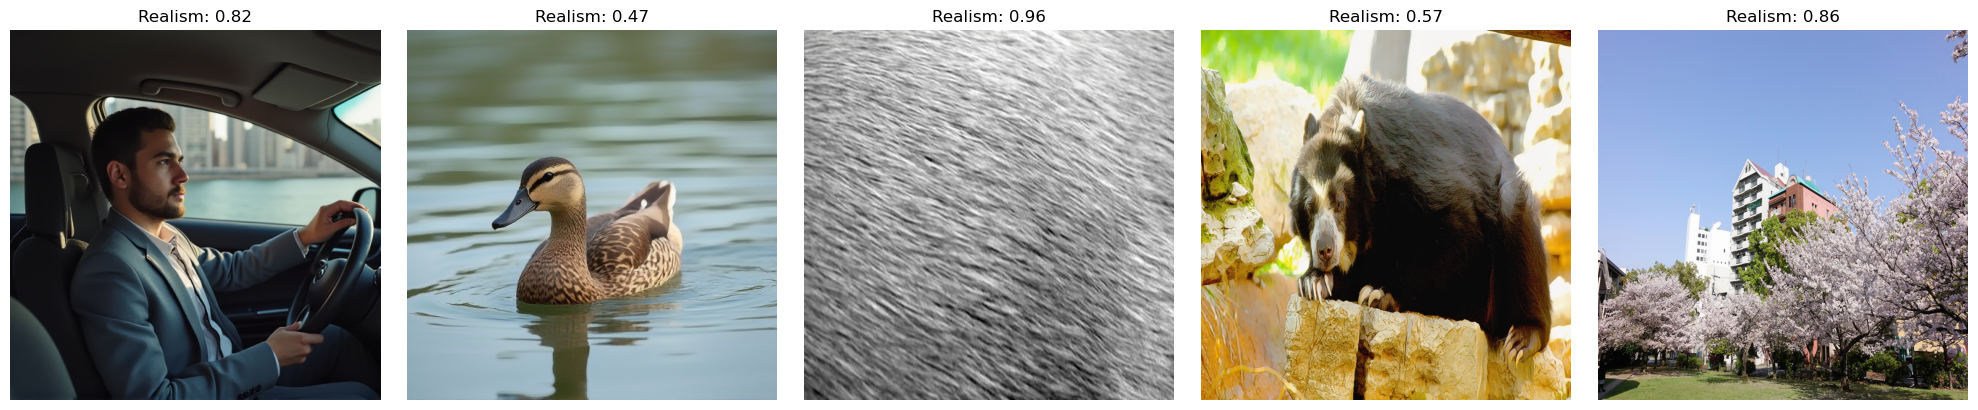

In [58]:
num_to_display = 5

fig, axes = plt.subplots(1, num_to_display, figsize=(20, 4))

for i in range(num_to_display):
    image_path = random.choice(image_paths)
    image = Image.open(image_path)    
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Realism: {extract_realism_score(os.path.basename(image_path))}")

plt.tight_layout()
plt.show()

## Data Preprocessing and Analysis

In [59]:
target_size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def preprocess_image(image_path, target_size= target_size):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean= mean, std= std)
    ])
    return transform(image)

def denormalize_image(tensor, mean= mean, std= std):
    tensor = tensor.clone().detach().numpy()
    denormalized = tensor * np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    clipped = np.clip(denormalized, 0, 1)
    return np.transpose(clipped, (1, 2, 0))


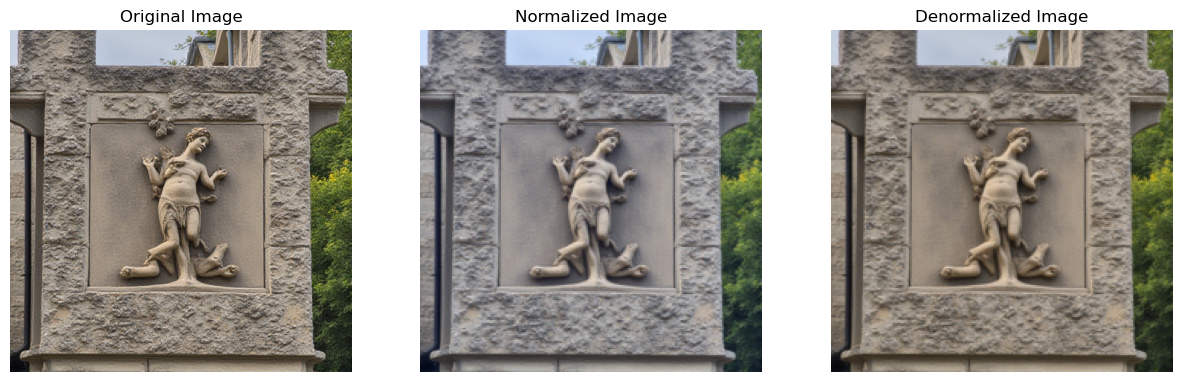

In [60]:
image_path = random.choice(image_paths)
original_image = Image.open(image_path).convert("RGB")
normalized_image = preprocess_image(image_path)
denormalized_image = denormalize_image(normalized_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

normalized_np = normalized_image.clone().detach().numpy()
normalized_np = np.transpose(normalized_np, (1, 2, 0))
axes[1].imshow((normalized_np - np.min(normalized_np)) / (np.max(normalized_np) - np.min(normalized_np))) 
axes[1].set_title("Normalized Image")
axes[1].axis("off")

axes[2].imshow(denormalized_image) 
axes[2].set_title("Denormalized Image")
axes[2].axis("off")

plt.show()


#### Plotting the distribution of realism scores in the dataset

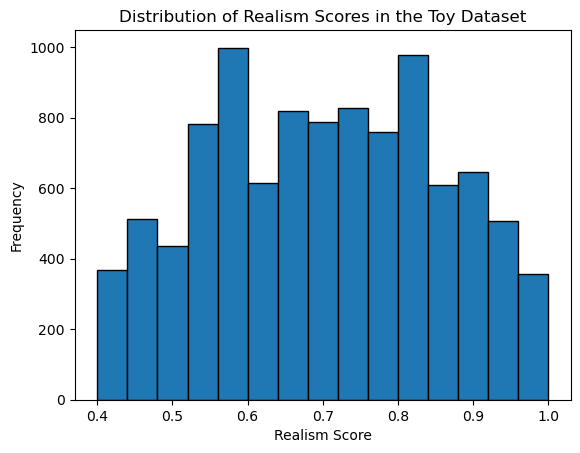

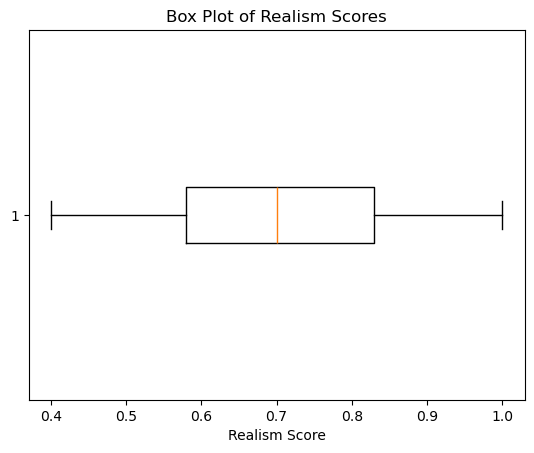

In [61]:
labels = []

for image_path in image_paths:
    score = extract_realism_score(os.path.basename(image_path))
    labels.append(score)

labels = np.array(labels)

plt.hist(labels, bins=15, edgecolor='black')
plt.xlabel('Realism Score')
plt.ylabel('Frequency')
plt.title('Distribution of Realism Scores in the Toy Dataset')
plt.show()

plt.boxplot(labels, vert=False)
plt.xlabel('Realism Score')
plt.title('Box Plot of Realism Scores')
plt.show()

#### Creating datasets

In [62]:
class RealismDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = preprocess_image(image_path)
        realism_score = extract_realism_score(os.path.basename(image_path))
        realism_score = torch.tensor(realism_score, dtype=torch.float32)
        return image, realism_score

def create_loaders(image_paths, batch_size= 32):
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
    val_paths, test_paths = train_test_split(val_paths, test_size=0.5, random_state=42)

    print(f"Training images: {len(train_paths)} | Validation images: {len(val_paths)} | Testing images: {len(test_paths)}")

    train_dataset = RealismDataset(train_paths)
    val_dataset = RealismDataset(val_paths)
    test_dataset = RealismDataset(test_paths)

    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [63]:
dataset = ["Flux+Real_10k 1/", "Flux+Real_10k 2/", "Flux+Real_10k 3/", "Flux+Real_10k 4/", "Flux+Real_10k 5/"]
image_paths = extract_dataset(dataset)
image_paths_5000 = extract_dataset(dataset, num_images=5000)
image_paths_2000 = extract_dataset(dataset, num_images=2000)

Found 2200 images in Flux+Real_10k 1/
Found 3920 images in Flux+Real_10k 2/
Found 1300 images in Flux+Real_10k 3/
Found 1301 images in Flux+Real_10k 4/
Found 1279 images in Flux+Real_10k 5/
Total images collected: 10000
Found 2200 images in Flux+Real_10k 1/
Found 3920 images in Flux+Real_10k 2/
Found 1300 images in Flux+Real_10k 3/
Found 1301 images in Flux+Real_10k 4/
Found 1279 images in Flux+Real_10k 5/
Total images collected: 10000
Randomly sampled 5000 images
Found 2200 images in Flux+Real_10k 1/
Found 3920 images in Flux+Real_10k 2/
Found 1300 images in Flux+Real_10k 3/
Found 1301 images in Flux+Real_10k 4/
Found 1279 images in Flux+Real_10k 5/
Total images collected: 10000
Randomly sampled 2000 images


## Model Design

In [64]:
class RegressionResNet(nn.Module):
    def __init__(self, resnet_type="resnet18", freeze_features=False):
        super(RegressionResNet, self).__init__()

        resnet_models = {
            "resnet18": models.resnet18,
            "resnet34": models.resnet34,
            "resnet50": models.resnet50,
            "resnet101": models.resnet101,
            "resnet152": models.resnet152,
        }

        if resnet_type not in resnet_models:
            raise ValueError(f"Invalid resnet_type '{resnet_type}'. Choose from: {list(resnet_models.keys())}")

        self.resnet = resnet_models[resnet_type](weights="DEFAULT")

        if freeze_features:
            for param in self.resnet.parameters():
                param.requires_grad = False
        
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.resnet(x)


## Training, Evaluation, Inference

In [65]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def compute_metrics(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            predictions.append(outputs.cpu())
            targets.append(labels.cpu())
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    mse = nn.MSELoss()(predictions, targets).item()
    mae = nn.L1Loss()(predictions, targets).item()
    
    # Compute R-squared: 1 - SSE / SST
    sse = torch.sum((targets - predictions) ** 2).item()
    sst = torch.sum((targets - torch.mean(targets)) ** 2).item()
    r_squared = 1 - sse / sst if sst > 0 else 0
    return mse, mae, r_squared

def plot_loss_curves(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

In [ ]:
def train_resnet_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, log_file,
                       num_epochs=15, early_stopping_patience= 5):

    training_losses = []
    validation_losses = []
    best_val_loss = float("inf")
    early_stopping_counter = 0

    with open(log_file, "a") as f:
        f.write(f"\n=====Training {model_name} for {num_epochs} epochs...=====\n")

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate_epoch(model, val_loader, criterion, device)
        mse, mae, r_squared = compute_metrics(model, val_loader, device)

        log_message = (
            f"Epoch {epoch+1}/{num_epochs}\n"
            f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}\n"
            f"Val Metrics --> MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r_squared:.4f}\n"
        )

        with open(log_file, "a") as f:
            f.write(log_message + "\n")

        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_{model_name}.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            with open(log_file, "a") as f:
                f.write("Early stopping triggered.\n")
            break

    with open(log_file, "a") as f:
        f.write(f"\n=====Training {model_name} Completed.=====\n")

    plot_loss_curves(training_losses, validation_losses)

def inference_on_test_set(model, saved_name, test_loader, device, log_file):
    model = inference.load_model(model, saved_name, device)

    predictions, actuals = inference.predict(model, test_loader, device)
    mse, mae, r_squared = inference.compute_metrics(predictions, actuals)


    log_message = (
        f"\n===== Test Results for {saved_name} =====\n"
        f"MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r_squared:.4f}\n"
        f"===== End of Test Results =====\n"
    )

    with open(log_file, "a") as f:
        f.write(log_message)

    inference.plot_predictions(model, test_loader, device, denorm_fn= denormalize_image, num_images= 5)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

subsets = {
    2000: image_paths_2000,
    5000: image_paths_5000,
}

progress_log_path = "progress_log.json"
training_log_path = "training_log.txt"
test_results_path = "test_results.txt"

if os.path.exists(progress_log_path):
    with open(progress_log_path, "r") as f:
        completed_runs = json.load(f)
else:
    completed_runs = {}


for subset_size, subset in subsets.items():
    for model_name in ["resnet18", "resnet34", "resnet50", "resnet101"]:
        run_key = f"{model_name}_{subset_size}"

        if run_key in completed_runs:
            print(f"Skipping {run_key} since it has already been completed.")
            continue

        print(f"\nTraining {model_name} on {subset_size} images...")
        print("===============================================")
        print("Creating data loaders...")
        train_loader, val_loader, test_loader = create_loaders(subset, batch_size= 32)

        model = RegressionResNet(resnet_type= model_name).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        print("Training the model...")
        train_resnet_model(model, train_loader, val_loader, criterion, optimizer, device, model_name= run_key, log_file= training_log_path,
                           num_epochs= 15, early_stopping_patience= 5)
        
        print("Evaluating the model on the test set...")
        inference_on_test_set(model, f"best_model_{model_name}_{subset_size}.pth", test_loader, device, test_results_path)
        
        print("===============================================")

        completed_runs[run_key] = "completed"

        # Save progress log
        with open(progress_log_path, "w") as f:
            json.dump(completed_runs, f, indent= 4)